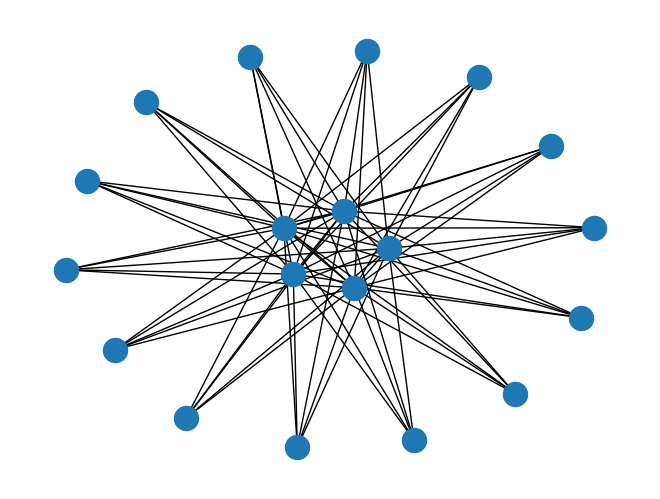

In [1]:
from turtle import up
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *
from model import UpdateRule


height = 1
width = 5
hidden_dim = 2048


n_inputs = 7
n_outputs = 7


# edges = build_edges(n_inputs, n_outputs, height, width)
# type_dict = {"hidden": [1, 0, 0], "input": [0, 1, 0], "output": [0, 0, 1]}
# total_hidden_dim = hidden_dim + len(type_dict["hidden"]) #hidden data + type
# n_nodes = height*width + n_inputs + n_outputs
# x = torch.zeros(n_nodes, total_hidden_dim)
# data = Data(edge_index=edges, x=x)
# graph = utils.to_networkx(data, to_undirected=True, remove_self_loops = True)
# nx.draw(graph)
# print(data.x.shape)

update_rule = UpdateRule(
    height,
    width,
    n_inputs, 
    n_outputs,
    hidden_dim,
    512
)
update_rule.draw()


In [2]:
from datasets import *
import copy
# dataset_loader = DataLoader(TranslateDataset(), batch_size=1, shuffle=True)

meta_set = MetaDataset()

update_rule = UpdateRule(
    height,
    width,
    n_inputs, 
    n_outputs,
    hidden_dim,
    2048
)
optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)

best_loss = 10000
best_model = None

n_steps = 2
batch_size = 4
for epoch in range(10000000):
    for _ in range(batch_size):
        for set_idx in meta_set.iterate():
            update_rule.reset() 
            x = update_rule.initial
            
        
            for idx, (problem_data_x, problem_data_y) in enumerate(meta_set.get_set(set_idx)):
                output_data = problem_data_y.float()
                if idx == meta_set.get_set_size() - 1:
                    output_data = None#problem_data_y.float()

                for i in range(n_steps):
                    output_node_data = torch.zeros(problem_data_y.shape)
                    x = update_rule(x, problem_data_x.float(), output_data)
                    
                
            network_output = update_rule.get_output(x)
            loss = F.mse_loss(problem_data_y.float().squeeze(0), network_output)
            
            loss.backward()  
    if loss < best_loss:
        best_model = copy.deepcopy(update_rule)
        best_loss = loss
        
    optimizer.step()  
    optimizer.zero_grad()  
        
    print(f"\r Epoch {epoch * batch_size} | Loss {loss} | Network in: {problem_data_x}| Network out: {network_output.detach()} ", end="")
    # print(f"\r Epoch {epoch * batch_size} | Loss {loss}", end="")
    
    if epoch % (100 // batch_size) == 0:
        print()


 Epoch 0 | Loss 0.12244897335767746 | Network in: tensor([[0, 0, 0, 0, 0, 1, 0]])| Network out: tensor([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429]) 
 Epoch 100 | Loss 0.12244723737239838 | Network in: tensor([[0, 0, 0, 0, 1, 0, 0]])| Network out: tensor([0.1429, 0.1428, 0.1429, 0.1429, 0.1428, 0.1429, 0.1428]) 
 Epoch 200 | Loss 0.1220908835530281 | Network in: tensor([[0, 0, 0, 0, 0, 0, 1]])| Network out: tensor([0.1440, 0.1417, 0.1429, 0.1436, 0.1418, 0.1441, 0.1417])  
 Epoch 300 | Loss 0.12001137435436249 | Network in: tensor([[0, 0, 0, 0, 0, 1, 0]])| Network out: tensor([0.1345, 0.1502, 0.1426, 0.1354, 0.1516, 0.1332, 0.1524]) 
 Epoch 400 | Loss 0.11859329789876938 | Network in: tensor([[1, 0, 0, 0, 0, 0, 0]])| Network out: tensor([0.1307, 0.1540, 0.1407, 0.1329, 0.1565, 0.1284, 0.1568]) 
 Epoch 500 | Loss 0.12279971688985825 | Network in: tensor([[0, 0, 0, 0, 0, 1, 0]])| Network out: tensor([0.1451, 0.1397, 0.1437, 0.1432, 0.1416, 0.1453, 0.1414]) 
 Epoch 600 | Loss 

KeyboardInterrupt: 

In [ ]:
import numpy as np
np.set_printoptions(precision=3)

run_rule(torch.tensor([[0,0,0,1]]), update_rule)

In [ ]:
#save update_rule model dont use state dict
torch.save(update_rule, "update_rule.pt")


In [ ]:

def run_rule_meta(update_rule, training, test, n_steps):
    x = update_rule.initial
    for (problem_x, problem_y) in training:
        print(problem_x)
        for _ in range(n_steps):
            x = update_rule(x, problem_x.float(), problem_y.float())
            
            
    for _ in range(n_steps):
        x = update_rule(x, test.float())
        
    network_output = update_rule.get_output(x).detach()
    return network_output
    

In [ ]:
# run_rule_meta(update_rule, torch.tensor([
#     ([1,0,0,0], [0,1,0,0]),
#     ([0,1,0,0], [0,0,1,0]),
#     ([0,0,1,0], [0,0,0,1]),
#     ]), torch.tensor([0,1,0,0]), 8)

run_rule_meta(best_model, torch.tensor([
    ([1,0,0,0,0,0,0], [0,0,0,0,0,0,1]),
    ([0,1,0,0,0,0,0], [1,0,0,0,0,0,0]),
    ([0,0,1,0,0,0,0], [0,1,0,0,0,0,0]),
    ]), torch.tensor([0,0,1,0,0,0,0]), 8)

tensor([1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0])


tensor([0.1415, 0.1436, 0.1418, 0.1435, 0.1432, 0.1425, 0.1438])

In [ ]:
best_loss

tensor(0.0064, grad_fn=<MseLossBackward0>)

In [ ]:
n = 7
arr = torch.arange(n)

In [ ]:
data =  DataLoader(TranslateDataset() , batch_size=1, shuffle=True)

for sample in data:
    print(sample)

[tensor([[0, 0, 0, 0, 0, 1, 0]]), tensor([[0, 0, 0, 0, 0, 0, 1]])]
[tensor([[0, 1, 0, 0, 0, 0, 0]]), tensor([[0, 0, 1, 0, 0, 0, 0]])]
[tensor([[0, 0, 0, 0, 0, 0, 1]]), tensor([[1, 0, 0, 0, 0, 0, 0]])]
[tensor([[0, 0, 0, 0, 1, 0, 0]]), tensor([[0, 0, 0, 0, 0, 1, 0]])]
[tensor([[0, 0, 0, 1, 0, 0, 0]]), tensor([[0, 0, 0, 0, 1, 0, 0]])]
[tensor([[1, 0, 0, 0, 0, 0, 0]]), tensor([[0, 1, 0, 0, 0, 0, 0]])]
